In [9]:
import tensorflow as tf

In [10]:
import nltk
import numpy as np
import pandas as pd
import io
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##**Collecting Data**

In [11]:
# Loaded in the all the movie reviews data stored on my computer
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset (5).csv


In [12]:
# storing dataset as a Pandas Dataframe
data = pd.read_csv(io.BytesIO(uploaded["IMDB Dataset (5).csv"]))

In [13]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [14]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [15]:
# Checking out the data
print(data.head())
print(data.shape)
print(data['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Dataset is balanced.



In [16]:
reviews = data['review']
print(reviews.head())
print(reviews.shape)
sentiment = data['sentiment']
print(sentiment.head())
print(sentiment.shape)

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object
(50000,)
0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object
(50000,)


## **PreProcessing The Data For ML**

In [17]:
def preprocess_text(review):

    #remove html tags
    soup = BeautifulSoup(review, 'html.parser')
    review_with_no_html = soup.get_text()
    #tokenizing the words, breaking up a sentence into [] of words
    words = word_tokenize(review_with_no_html)
    #remove punctuation
    punctuation = set(string.punctuation)
    words = [word for word in words if word not in punctuation]
    #remove stopwords
    sw = set(stopwords.words("english"))
    words = [word for word in words if word.lower() not in sw]
    #remove non-alphabetic words
    words = [word for word in words if word.isalpha()]
    #using SnowBallStemmer to stem each word
    #For example, the words 'walk', 'walked', 'walks' or 'walking' will be all converted to the base form 'walk'
    snowball = SnowballStemmer(language = 'english')
    stemmed_words = [snowball.stem(word) for word in words]

    preprocessed_review = ' '.join(stemmed_words)
    return preprocessed_review

In [18]:
preprocessed_reviews = reviews.apply(preprocess_text)

<ipython-input-17-499687a307f5>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(review, 'html.parser')


In [19]:
print(reviews.head())
print(preprocessed_reviews.head())

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object
0    one review mention watch oz episod hook right ...
1    wonder littl product film techniqu fashion giv...
2    thought wonder way spend time hot summer weeke...
3    basic famili littl boy jake think zombi closet...
4    petter mattei love time money visual stun film...
Name: review, dtype: object


## **Prepare Data For Neutral Network**

In [20]:
# will ignore words that appear in less than 0.102% of the Reviews and more than 70% of the Reviews
bag_of_words_tool = CountVectorizer(min_df=0.00102,max_df=0.7)

In [21]:
# now we have a bunch of words, bag of words will count how many of each word is in the sentence. Ex: 'the' appears 4 times in this sentence
preprocessed_reviews_with_bagOfWords = bag_of_words_tool.fit_transform(preprocessed_reviews)

In [22]:
print(preprocessed_reviews_with_bagOfWords.shape)
# the type is now a sparse matrix have to convert back to Dataframe
print(type(preprocessed_reviews_with_bagOfWords))

(50000, 6924)
<class 'scipy.sparse._csr.csr_matrix'>


In [23]:
# converting back to Dataframe
data_is_ready = pd.DataFrame.sparse.from_spmatrix(preprocessed_reviews_with_bagOfWords)
print(data_is_ready.shape)
print(type(data_is_ready))

(50000, 6924)
<class 'pandas.core.frame.DataFrame'>


In [24]:
# label encoder, is just labeling our sentiment as 1 or 0, for example positive=1 and negative=0
label_encoder = LabelEncoder()
encoded_sentiment = label_encoder.fit_transform(sentiment)
print(encoded_sentiment.shape)
print(encoded_sentiment)

(50000,)
[1 1 1 ... 0 0 0]


In [25]:
# spliting all of the data into training and testing set, 50& will go to training and 50% will be saved for testing
x_train, x_test, y_train, y_test = train_test_split(data_is_ready, encoded_sentiment, random_state=3, train_size=0.50)
print('training_set x size: ', x_train.shape)
print('training_set y size: ', y_train.shape)
print('testing_set x size: ', x_test.shape)
print('testing_set y size: ', y_test.shape)

training_set x size:  (25000, 6924)
training_set y size:  (25000,)
testing_set x size:  (25000, 6924)
testing_set y size:  (25000,)


## **Time To Apply Neutral Network**

In [26]:
# Now we will create a Neural Network Model! configuring it like how many layers (I have set it to 5), and how many neutrons in each layers ..
# these hyperparameter need to be iterately modified after testing to optimize to imporve performance

model = tf.keras.Sequential ([
    tf.keras.layers.Dense (256, activation = 'relu',
                           input_shape = (x_train.shape[1],),
                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.001, l2=0.025)),
    tf.keras.layers.Dense (128, activation = 'relu'),
    tf.keras.layers.Dense (64, activation = 'relu'),
    tf.keras.layers.Dense (32, activation = 'relu'),
    tf.keras.layers.Dense (2, activation = 'softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Adam optimization: a gradient descent method that is "computationally efficient, has little memory requirement, is well suited for problems that are large in terms of data/parameters"
# Use this SparseCategoricalCrossentropy crossentropy loss function when there are two or more label classes.
# Accuracy metric: calculates how often predictions equal labels.
model.compile (tf.keras.optimizers.Adam (learning_rate = 0.0001),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =True),
               metrics = ['accuracy'])

In [28]:
model.summary ()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │       1,772,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,816,098 (6.93 MB)

 Trainable params: 1,816,098 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

Total params: 1,816,098
What does this mean? It is # of links between the neutons, each link has different 'weights' and 'bais'. It is interesting because the Neutral Networks Deep Learning is creating these links themselves! kind of like making their own conclusions in a way "thinking"

Quick side comment: Humans brains have approx over trillions of connections.

In [29]:
print(type(x_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [30]:
# calculating the loss function for each "epoch" and trying to adjust the model to optimize performance
history = model.fit (x_train.to_numpy(), y_train,
                          validation_data=(x_test.to_numpy(), y_test),
                          epochs = 5)
history

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7283 - loss: 14.1204 - val_accuracy: 0.8536 - val_loss: 0.6679
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8646 - loss: 0.6386 - val_accuracy: 0.8572 - val_loss: 0.6159
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8723 - loss: 0.5681 - val_accuracy: 0.8685 - val_loss: 0.5528
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8799 - loss: 0.5249 - val_accuracy: 0.8642 - val_loss: 0.5468
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8844 - loss: 0.5002 - val_accuracy: 0.8708 - val_loss: 0.5247


The training score is 88% and testing score is 87%, only 1% diff, therefore accurate model!

Next steps would be to keep on tuning the hyperparameters to find the highest training score with the keeping an acceptable diff with testing score

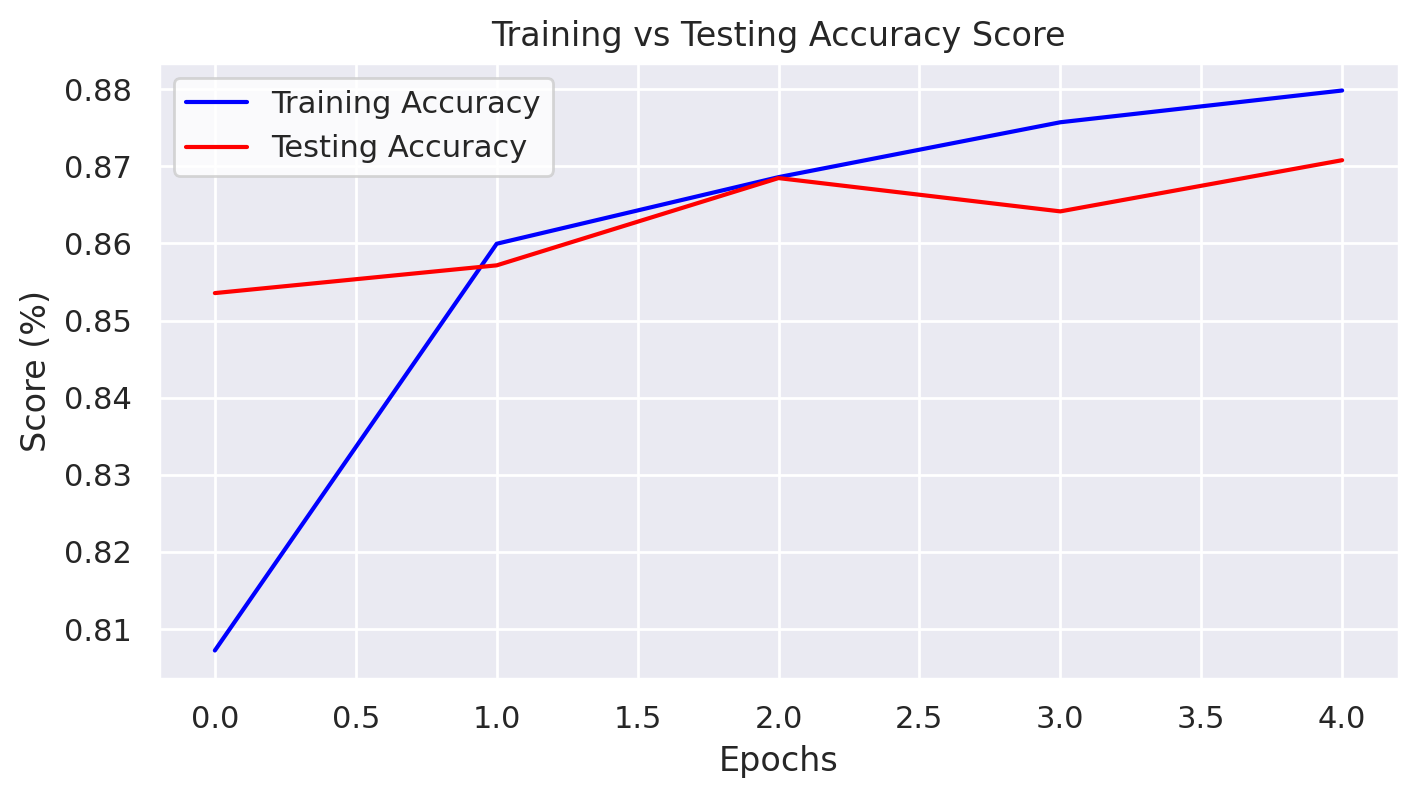

In [40]:
# Plot training score vs testing score of model for each epoch
plt.figure(figsize=(8, 4), dpi=200)
with sns.axes_style('darkgrid'):
  ax1 = sns.lineplot(history.history['accuracy'], label='Training Accuracy', color='blue')
  ax2 = sns.lineplot(history.history['val_accuracy'], label='Testing Accuracy', color='red')
plt.title('Training vs Testing Accuracy Score')
plt.xlabel('Epochs')
plt.ylabel('Score (%)')
plt.legend()